# Creating New Features

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

### Preparing credit data

In [2]:
default = pd.read_csv('../data/credit_card_default.csv', index_col="ID")
default.rename(columns=lambda x: x.lower(), inplace=True)
default.rename(columns={'pay_0':'pay_1','default payment next month':'default'}, inplace=True)

default['male'] = (default['sex']==1).astype('int')
default.drop('sex', axis=1, inplace=True)

default['married'] = (default['marriage'] == 1).astype('int')
default.drop('marriage', axis=1, inplace=True)

# For pay_n features if >0 then it means the customer was delayed on that month
pay_features = ['pay_' + str(i) for i in range(1,7)]
for p in pay_features:
    default[p] = (default[p] > 0).astype(int)

## Creating features from context

### Another way to encode education information

In [3]:
def transform_education(x):
    if x==1: # 1==graduate school, give it a 2
        return 2
    elif x==2: # 2==university, give it a 1
        return 1
    else:
        return -1 # give a negative value to all other levels of education
    
default['education'] = default['education'].apply(transform_education)

In [4]:
default.groupby(['married','male'])['default'].mean().unstack()

male,0,1
married,,
0,0.197345,0.227979
1,0.219625,0.259345


### Bill amount minus payment

Since we now that for each month we have the bill amount and the payment amount that the client made to his credit card account, it makes sense to calculate the difference and it may be indicative of future default status.

In [5]:
for i in range(1,7):
    i = str(i)
    new_var_name = 'bill_minus_pay' + i
    default[new_var_name] = default['bill_amt'+i] - default['pay_amt'+i]

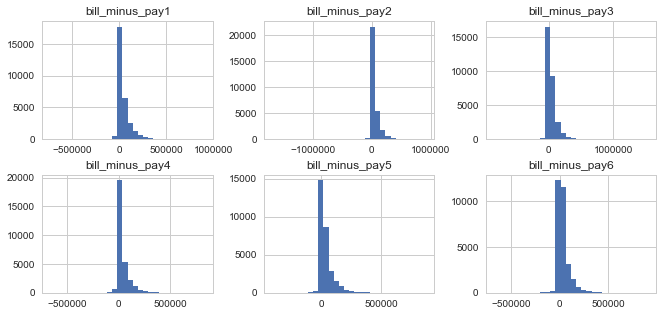

In [6]:
bill_minus_pay_features = ['bill_minus_pay'+str(i) for i in range(1,7)]
default[bill_minus_pay_features].hist(figsize=(11,5), layout=(2,3), bins=30);

## Using PCA to create new features

### Reducing the 6 bill amount features to 1

In [7]:
from sklearn.decomposition import PCA

In [8]:
bill_amt_features = ['bill_amt'+str(i) for i in range(1,7)]
bill_amt_pca = PCA(n_components=1)
default['bill_amt_new_feat'] = bill_amt_pca.fit_transform(default[bill_amt_features])[:,0]

### Reducing the 5 pay_i features to 2

Since we know that pay_1 is important we will keep it as is.

In [9]:
pay_features = ['pay_'+str(i) for i in range(2,7)]
pay_features_pca = PCA().fit(default[pay_features])
pay_features_pca.explained_variance_ratio_

array([ 0.62640566,  0.15478995,  0.10049793,  0.07279835,  0.04550811])

In [10]:
pay_features_pca = PCA(n_components=2).fit_transform(default[pay_features])
default['new_pay1'] = pay_features_pca[:,0]
default['new_pay2'] = pay_features_pca[:,1]

## Diamonds dataset

In [11]:
# importing data
data_path= '../data/diamonds.csv'
diamonds = pd.read_csv(data_path)
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['cut'], prefix='cut', drop_first=True)],axis=1)
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['color'], prefix='color', drop_first=True)],axis=1)
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['clarity'], prefix='clarity', drop_first=True)],axis=1)
diamonds.drop(['cut','color','clarity'], axis=1, inplace=True)

In [12]:
diamonds.head()

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,1,0,0,...,0,0,1,0,0,1,0,0,0,0


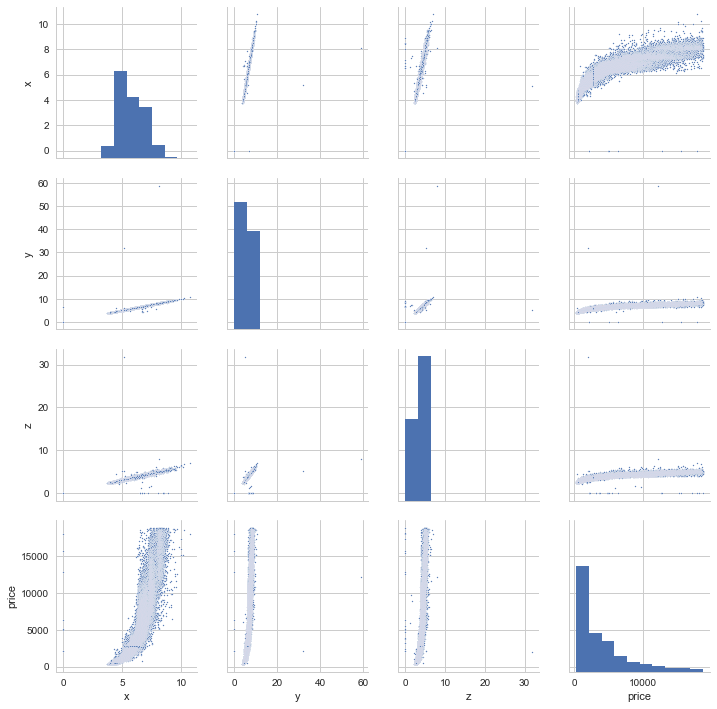

In [13]:
sns.pairplot(diamonds[['x','y','z','price']], plot_kws={'s':2});

In [14]:
diamonds['volume'] = diamonds['x']*diamonds['y']*diamonds['z']

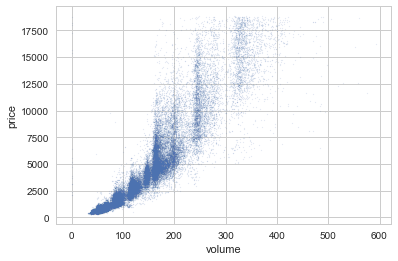

In [15]:
diamonds[diamonds['volume']<600].plot.scatter(x='volume', y='price', s=1, alpha=0.1);

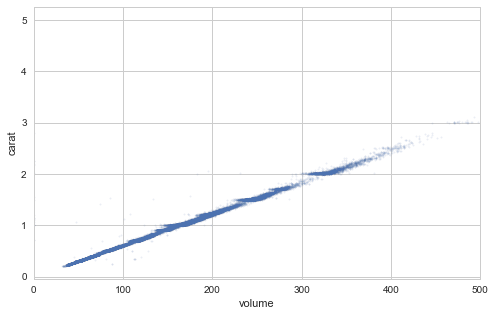

In [16]:
fig, ax = plt.subplots(figsize=(8,5))
diamonds.plot.scatter(x='volume', y='carat', s=2, alpha=0.1, ax=ax)
ax.set_xlim(0,500);

In [17]:
diamonds[['price','carat','volume']].corr()

,price,carat,volume
price,1.000000,0.921591,0.902385
carat,0.921591,1.000000,0.976308
volume,0.902385,0.976308,1.000000
